# Short-term Temperature Model Test

## Import dependencies and data

In [1]:
# import dependencies
import os
import json
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import tensorflow as tf

from tensorflow.keras import layers, Model
#from scipy.fftpack import fft, ifft, fftfreq

In [2]:
# define relevant paths
home_path = os.path.dirname(os.getcwd())
data_path = home_path + '\\data\\'
plot_path = home_path + '\\plotting\\plots\\'
save_path = home_path + '\\model\\saved\\'

In [3]:
# get merged data
data = pd.read_csv(
    data_path + 'data_merged.csv',
    header=[0, 1],
    index_col=[0, 1, 2, 3, 4]
)

# convert index.date col to datetime
#data.index = pd.to_datetime(data.index.values)
data.loc[:, ('time', 'date')] = pd.to_datetime(data.time.date)

In [4]:
# define X vars
x_vars = [
    ('flow', 'TA01_GP101'),
    ('flow', 'TA02_GP101'),
    ('state', 'TA01_output'),
    ('state', 'TA02_output'),
    ('power', 'phase'),
    ('temperatures', 'TA01_GT10X_GM10X'),
    ('temperatures', 'DC_GT101_GM101'),
    ('temperatures', 'DC_GT102_GM102'),
    ('temperatures', 'DC_GT103_GM103'),
    ('temperatures', 'DC_GT104_GM104'),
    ('temperatures', 'DC_GT401_GM401'),
    ('temperatures', 'TA01_GT401_GM401'),
    ('temperatures', 'TA02_GT401_GM401'),
    ('temperatures', 'DC_GT301_damped'),
    ('temperatures', 'DC_GT301_outdoor'),
    ('humidity', 'TA01_GT10X_GM10X'),
    ('humidity', 'DC_GT101_GM101'),
    ('humidity', 'DC_GT102_GM102'),
    ('humidity', 'DC_GT103_GM103'),
    ('humidity', 'DC_GT104_GM104'),
    ('humidity', 'DC_GT401_GM401'),
    ('humidity', 'TA01_GT401_GM401'),
    ('humidity', 'TA02_GT401_GM401'),
    ('humidity', 'outdoor'),
    ('setpoints', 'TA01_GT10X_GM10X'),
    ('sun', 'gsi'),
    ('sun', 'gsi_deriv'),
    ('sun', 'vol'),
    ('sun', 'vol_deriv'),
    ('wind', 'Wx'),
    ('wind', 'Wy'),
    ('time', 'dayofyear'),
    ('time', 'monthofyear'),
    ('time', 'minofday'),
    ('time', 'hourofday')
]

# filter columns to keep only x_vars
data = data[x_vars].copy()

## Describe Df

In [5]:
# print number of NAs
print('Number of NAs\n')
print(data.isna().sum())
print('\n\n')

Number of NAs

category      sensor_ID       
flow          TA01_GP101             13
              TA02_GP101             11
state         TA01_output            15
              TA02_output            14
power         phase               20854
temperatures  TA01_GT10X_GM10X       14
              DC_GT101_GM101         12
              DC_GT102_GM102         12
              DC_GT103_GM103         11
              DC_GT104_GM104         11
              DC_GT401_GM401         13
              TA01_GT401_GM401       13
              TA02_GT401_GM401       12
              DC_GT301_damped        12
              DC_GT301_outdoor       12
humidity      TA01_GT10X_GM10X       15
              DC_GT101_GM101         12
              DC_GT102_GM102         12
              DC_GT103_GM103         12
              DC_GT104_GM104         10
              DC_GT401_GM401         14
              TA01_GT401_GM401       14
              TA02_GT401_GM401       12
              outdoor             

In [6]:
# remove single NAN
data = data.dropna(how='any')

In [7]:
cols = [
    'DC_GT101_GM101',
    'DC_GT102_GM102',
    'DC_GT103_GM103',
    'DC_GT104_GM104'
]

for col in cols:
    data[('flag', col)] = (((data.temperatures[col] - data.temperatures[col].shift(1)) < -1) \
                            & ((data.humidity[col] - data.humidity[col].shift(1)) > 5)) \
                            | (data.humidity[col] > 70)

    hrs = data.groupby(['month', 'day', 'hour']).sum()[('flag', col)] > 0
    hrsDrop = hrs[hrs == 1].index.values
    mask = np.array([hr not in list(hrsDrop) for hr in data.index.droplevel(-1).droplevel(-1).values])
    data = data[mask]
    
    hrs = data.groupby(['month', 'day', 'hour']).var()[('humidity', col)] > 40
    hrsDrop = hrs[hrs == 1].index.values
    mask = np.array([hr not in list(hrsDrop) for hr in data.index.droplevel(-1).droplevel(-1).values])
    data = data[mask]
    
#     days = data.groupby(['month', 'day']).sum()[('flag', col)] > 0
#     daysDrop = days[days == 1].index.values
#     mask = np.array([day not in list(daysDrop) for day in data.index.droplevel(-1).droplevel(-1).droplevel(-1).values])
    

# Feature engineering


### Relative to absolute humidity

In [8]:
def abs_humid(temp, rel_humid):
    abs_humidity =  6.112 * np.exp(17.67 * temp / (temp + 243.5)) * rel_humid * 2.1674 / (273.15 + temp)
    return abs_humidity

def rel_humid(temp, abs_humid):
    rel_humidity = abs_humid * (273.15 + temp) / (6.112 * np.exp(17.67 * temp / (temp + 243.5)) * 2.1674)
    return rel_humidity

In [9]:
sensors = [
    'DC_GT101_GM101',
    'DC_GT102_GM102',
    'DC_GT103_GM103',
    'DC_GT104_GM104',
    'TA01_GT10X_GM10X',
    'TA01_GT401_GM401',
    'TA02_GT401_GM401'
]

for sensor in sensors:
    data[('humidity', sensor + '_abs')] = abs_humid(data.temperatures[sensor], data.humidity[sensor])

data[('humidity', 'outdoor_abs')] = abs_humid(data.temperatures.DC_GT301_outdoor, data.humidity.outdoor)


### Abs. humidity relative to GH

In [10]:
data[('humidity', 'TA01_GT401_GM401_rel')] = data[('humidity', 'TA01_GT401_GM401_abs')] - data[('humidity', 'TA01_GT10X_GM10X_abs')]
data[('humidity', 'TA02_GT401_GM401_rel')] = data[('humidity', 'TA02_GT401_GM401_abs')] - data[('humidity', 'TA01_GT10X_GM10X_abs')]
data[('humidity', 'outdoor_rel')] = data[('humidity', 'outdoor_abs')] - data[('humidity', 'TA01_GT10X_GM10X_abs')]

### Convert temperature measurements to DIFF

In [11]:
data[('temperatures', 'TA01_GT401_GM401_rel')] = data[('temperatures', 'TA01_GT401_GM401')] - data[('temperatures', 'TA01_GT10X_GM10X')]
data[('temperatures', 'TA02_GT401_GM401_rel')] = data[('temperatures', 'TA02_GT401_GM401')] - data[('temperatures', 'TA01_GT10X_GM10X')]
data[('temperatures', 'DC_GT301_outdoor_rel')] = data[('temperatures', 'DC_GT301_outdoor')] - data[('temperatures', 'TA01_GT10X_GM10X')]
data[('temperatures', 'DC_GT301_damped_rel')] = data[('temperatures', 'DC_GT301_damped')] - data[('temperatures', 'TA01_GT10X_GM10X')]

### DC-temp scaling

In [12]:
# ta01_min = 1784.75
# ta01_max = 5173.86

# ta02_min = 0.0
# ta02_max = 5248.95

In [13]:
ta01_min = 35
ta01_max = 75

ta02_min = 0
ta02_max = 85

In [14]:
# data[('flow', 'TA01_minmax')] = (data.flow.TA01_GP101 - ta01_min) / (ta01_max - ta01_min)
# data[('flow', 'TA02_minmax')] = (data.flow.TA02_GP101 - ta02_min) / (ta02_max - ta02_min)

# data[('temperatures', 'DC_GT401_GM401_scaled')] = data.temperatures.DC_GT401_GM401 * data.flow.TA01_minmax
# data[('temperatures', 'TA01_GT401_GM401_scaled')] = data.temperatures.TA01_GT401_GM401 * data.flow.TA01_minmax
# data[('temperatures', 'DC_GT301_damped_scaled')] = data.temperatures.DC_GT301_damped * data.flow.TA02_minmax

data[('state', 'TA01_output_minmax')] = data.state.TA01_output / ta01_min
data[('state', 'TA02_output_minmax')] = data.state.TA02_output / ta01_min
# data[('state', 'TA01_output_minmax')] = (data.state.TA01_output - ta01_min) / (ta01_max - ta01_min)
# data[('state', 'TA02_output_minmax')] = (data.state.TA02_output - ta02_min) / (ta02_max - ta02_min)

# data[('temperatures', 'DC_GT401_GM401_scaled')] = data.temperatures.DC_GT401_GM401_rel * data.state.TA01_output_minmax
data[('temperatures', 'TA01_GT401_GM401_scaled')] = data.temperatures.TA01_GT401_GM401_rel * data.state.TA01_output_minmax
data[('temperatures', 'TA02_GT401_GM401_scaled')] = data.temperatures.TA02_GT401_GM401_rel * data.state.TA02_output_minmax
data[('temperatures', 'DC_GT301_damped_scaled')] = data.temperatures.DC_GT301_damped_rel * data.state.TA02_output_minmax
data[('temperatures', 'DC_GT301_outdoor_scaled')] = data.temperatures.DC_GT301_outdoor_rel * data.state.TA02_output_minmax

In [15]:
# data[('temperatures', 'TA_inflow')] = data.temperatures.TA01_GT401_GM401_scaled + data.temperatures.DC_GT301_damped_scaled
# data[('temperatures', 'TA_inflow')] = data.temperatures.TA01_GT401_GM401_scaled + data.temperatures.DC_GT301_outdoor_scaled
data[('temperatures', 'TA_inflow')] = data.temperatures.TA01_GT401_GM401_scaled + data.temperatures.TA02_GT401_GM401_scaled

### Same f. humidity

In [16]:
data[('humidity', 'TA01_GT401_GM401_scaled')] = data.humidity.TA01_GT401_GM401_rel * data.state.TA01_output_minmax
data[('humidity', 'TA02_GT401_GM401_scaled')] = data.humidity.TA02_GT401_GM401_rel * data.state.TA02_output_minmax
data[('humidity', 'outdoor_scaled')] = data.humidity.outdoor_rel * data.state.TA02_output_minmax

In [17]:
# data[('humidity', 'TA_inflow')] = data.humidity.TA01_GT401_GM401_scaled + data.humidity.outdoor_scaled
data[('humidity', 'TA_inflow')] = data.humidity.TA01_GT401_GM401_scaled + data.humidity.TA02_GT401_GM401_scaled

## Split TRAIN / TEST

In [18]:
## Randomly select days for trainin and testing
days = data.groupby(['month', 'day'], sort=False).count().index.values

# get number of days f. testing / training
train_frac = 0.95
train_n = int(len(days) * train_frac)
test_n = len(days) - train_n

# split dataset
#np.random.shuffle(days)
mask = np.array([day in list(days[:train_n]) for day in data.index.droplevel(-1).droplevel(-1).droplevel(-1).values])
data_train = data.loc[mask].copy()
data_test = data.loc[~mask].copy()

# del data

## NOISE reduction

### Aggregate TRAIN data

In [19]:
### create "better" estimate of temperature var, w. proper avg.
data_train[('temperatures', 'TA01_GT10X_GM10X')] = data_train.temperatures[[
#     ('DC_GT101_GM101'),
    ('DC_GT102_GM102'), 
    ('DC_GT103_GM103'), 
    ('DC_GT104_GM104')
]].values.mean(axis=1)

# # adjust for setpoint change
# data_train[('temperatures', 'TA01_GT10X_GM10X')] += (20.0 - data_train[('setpoints', 'TA01_GT10X_GM10X')])

In [20]:
### create "better" estimate of humidity var, w. proper avg.
data_train[('humidity', 'TA01_GT10X_GM10X')] = data_train.humidity[[
    # ('DC_GT102_GM101'),
    ('DC_GT102_GM102'), 
    ('DC_GT103_GM103'), 
    ('DC_GT104_GM104')
]].values.mean(axis=1)

In [21]:
### create "better" estimate of humidity var, w. proper avg.
data_train[('humidity', 'TA01_GT10X_GM10X_abs')] = data_train.humidity[[
    # ('DC_GT102_GM101_abs'),
    ('DC_GT102_GM102_abs'), 
    ('DC_GT103_GM103_abs'), 
    ('DC_GT104_GM104_abs')
]].values.mean(axis=1)

### Agreggate TEST data

In [22]:
### create "better" estimate of temperature var, w. proper avg.
data_test[('temperatures', 'TA01_GT10X_GM10X')] = data_test.temperatures[[
    # ('DC_GT102_GM101'),
    ('DC_GT102_GM102'), 
    ('DC_GT103_GM103'), 
    ('DC_GT104_GM104')
]].values.mean(axis=1)


# # adjust for setpoint change
# data_test[('temperatures', 'TA01_GT10X_GM10X')] += (20.0 - data_test[('setpoints', 'TA01_GT10X_GM10X')])

In [23]:
### create "better" estimate of humidity var, w. proper avg.
data_test[('humidity', 'TA01_GT10X_GM10X')] = data_test.humidity[[
    # ('DC_GT102_GM101'),
    ('DC_GT102_GM102'), 
    ('DC_GT103_GM103'), 
    ('DC_GT104_GM104')
]].values.mean(axis=1)

In [24]:
### create "better" estimate of humidity var, w. proper avg.
data_test[('humidity', 'TA01_GT10X_GM10X_abs')] = data_test.humidity[[
    # ('DC_GT102_GM101_abs'),
    ('DC_GT102_GM102_abs'), 
    ('DC_GT103_GM103_abs'), 
    ('DC_GT104_GM104_abs')
]].values.mean(axis=1)

### Reduce to M-min observations

In [25]:
# set min per observation
m = 5

In [26]:
# # reduce to one OBS per 5 MIN (take average of 10 OBS)
idxObj = zip(
    data_train.index.get_level_values(0),
    data_train.index.get_level_values(1),
    data_train.index.get_level_values(2),
    data_train.index.get_level_values(3) // m
)

index = pd.MultiIndex.from_tuples(
    tuples=idxObj,
    names=['month', 'day', 'hour', 'minute']
)

data_train.index = index
data_train = data_train.groupby(['month', 'day', 'hour', 'minute'], sort=False).mean()

In [27]:
# # reduce to one OBS per 5 MIN (take average of 10 OBS)
idxObj = zip(
    data_test.index.get_level_values(0),
    data_test.index.get_level_values(1),
    data_test.index.get_level_values(2),
    data_test.index.get_level_values(3) // m
)

index = pd.MultiIndex.from_tuples(
    tuples=idxObj,
    names=['month', 'day', 'hour', 'minute']
)

data_test.index = index
data_test = data_test.groupby(['month', 'day', 'hour', 'minute'], sort=False).mean()

### Normalization

In [28]:
# Define model variables
model_vars = [
#     ('temperatures', 'TA_inflow'),
#     ('humidity', 'TA_inflow'),
#     ('state', 'TA01_output'),
#     ('state', 'TA02_output'),
#     ('flow', 'TA01_GP101'),
#     ('flow', 'TA02_GP101'),
#     ('temperatures', 'DC_GT102_GM102'),
#     ('temperatures', 'DC_GT103_GM103'),
#     ('temperatures', 'DC_GT104_GM104'),
    ('temperatures', 'TA01_GT10X_GM10X'),
    ('temperatures', 'TA01_GT401_GM401_scaled'),
    ('temperatures', 'TA02_GT401_GM401_scaled'),
#     ('temperatures', 'DC_GT301_damped_scaled'),
#     ('temperatures', 'DC_GT301_outdoor_scaled'),
#     ('temperatures', 'DC_GT401_GM401'),
    ('temperatures', 'TA01_GT401_GM401'),
    ('temperatures', 'TA02_GT401_GM401'),
#     ('temperatures', 'DC_GT301_damped'),
    ('temperatures', 'DC_GT301_outdoor'),
#     ('humidity', 'TA01_GT10X_GM10X'),
    ('humidity', 'TA01_GT10X_GM10X_abs'),
    ('humidity', 'TA01_GT401_GM401_abs'),
    ('humidity', 'TA02_GT401_GM401_abs'),
    ('humidity', 'outdoor_abs'),
    ('humidity', 'TA01_GT401_GM401_scaled'),
    ('humidity', 'TA02_GT401_GM401_scaled'),
#     ('humidity', 'outdoor_scaled'),
    ('sun', 'gsi'),
#     ('sun', 'gsi_deriv'),
#     ('sun', 'vol'),
#     ('sun', 'vol_deriv'),
#     ('wind', 'Wx'),
#     ('wind', 'Wy'),
    ('power', 'phase'),
    ('time', 'minofday'),
    ('time', 'dayofyear')
]

# filter data
data_train = data_train[model_vars].copy()
data_test = data_test[model_vars].copy()

In [29]:
col_params = {}
for col in data_train.columns:
    cat, var = col
    
#     if cat == 'temperatures' and var == 'TA01_GT10X_GM10X':
#         continue
    
    min_val = data_train[col].min()
    max_val = data_train[col].max()
    
    # normalize
    mean = data_train[col].mean()
    std = data_train[col].std()
    
    data_train[col] = (data_train[col] - mean) / std
    data_test[col] = (data_test[col] - mean) / std
    
#     # make positive
#     min_val = data_train[col].min()
#     data_train[col] = data_train[col] + abs(min(0, min_val))
#     min_val = max(0, min_val)
#     max_val = data_train[col].max()
#     data_train[col] = (data_train[col] - min_val) / (max_val - min_val)
    
#     data_test[col] = data_test[col] + abs(min(0, min_val))
#     data_test[col] = (data_test[col] - min_val) / (max_val - min_val)
#     data_test[col] = data_test[col].apply(lambda val: max(val, 0.0))
# #     data_test[col] = data_test[col].apply(lambda val: max(min(val, 1.0), 0.0))
    
    col_params[col] = {
        'mean':mean,
        'std':std,
        'max':max_val,
        'min':min_val
    }

In [30]:
# ta01_max, ta01_min = col_params[('state', 'TA01_output')]['max'], col_params[('state', 'TA01_output')]['min']
# ta02_max, ta02_min = col_params[('state', 'TA02_output')]['max'], col_params[('state', 'TA02_output')]['min']

## Data preparation

In [31]:
t_steps = 3    # 5 x 2 = 10-min predictions
n_steps = 12    # 5 x 12 = 60-min backwards look

In [32]:
# targets_train = data_train[('temperatures', 'TA01_GT10X_GM10X')].copy()
# targets_test = data_test[('temperatures', 'TA01_GT10X_GM10X')].copy()

In [33]:
targets_train = pd.concat([data_train.pop(col) for col in [
#     ('temperatures', 'DC_GT102_GM102'),
#     ('temperatures', 'DC_GT103_GM103'),
#     ('temperatures', 'DC_GT104_GM104'),
    ('temperatures', 'TA01_GT10X_GM10X'),
    ('humidity', 'TA01_GT10X_GM10X_abs')
]], axis=1)

targets_test = pd.concat([data_test.pop(col) for col in [
#     ('temperatures', 'DC_GT102_GM102'),
#     ('temperatures', 'DC_GT103_GM103'),
#     ('temperatures', 'DC_GT104_GM104'),
    ('temperatures', 'TA01_GT10X_GM10X'),
    ('humidity', 'TA01_GT10X_GM10X_abs')
]], axis=1)

In [34]:
# state_train = pd.concat([data_train.pop(col) for col in [
#     ('temperatures', 'TA01_GT401_GM401_scaled'),
#     ('temperatures', 'DC_GT301_outdoor_scaled'),
#     ('humidity', 'TA01_GT401_GM401_scaled'),
#     ('humidity', 'outdoor_scaled'),
# ]], axis=1)

# state_test = pd.concat([data_test.pop(col) for col in [
#     ('temperatures', 'TA01_GT10X_GM10X'),
#     ('humidity', 'TA01_GT10X_GM10X_abs'),
#     ('humidity', 'TA01_GT401_GM401_scaled'),
#     ('humidity', 'outdoor_scaled'),
# ]], axis=1)

In [35]:
temps_train = targets_train[:-n_steps]#.values
temps_test = targets_test[:-n_steps]#.values

### Create sequences

In [36]:
def date_flagger(data, n_steps):
    # get flagged datesvalues
#     data['minute'] = data.index.get_level_values(3).values    
#     data['date_flag'] = data.minute - data.minute.shift(n_steps) != (n_steps)

    data['hour'] = data.index.get_level_values(2).values    
    data['date_flag'] = data.hour - data.hour.shift(n_steps) > 1
    
    # get positions in data, w.r.t. n_step removed observations at start
    flagged_idx = np.where(data.date_flag.values == 1)
    flagged_idx = flagged_idx[0] - n_steps
    
    del data['hour'], data['date_flag']
    
    return flagged_idx

In [37]:
def seq_maker(data, targets, temps, n_steps):
    
    vals = data.values
    sequences = []
    for i in range(len(vals) - n_steps):
        sequences.append(vals[i:i+n_steps])
    sequences = np.stack(sequences)
    
    flags = date_flagger(data, n_steps)
    mask = [idx not in flags for idx in range(len(sequences))]
    
    sequences = sequences[mask]
    targets = targets[n_steps:][mask].values
    temps = temps[mask].values
    
    return sequences, targets, temps

In [38]:
# make sequences
sequences_train, targets_train, temps_train = seq_maker(data_train, targets_train, temps_train, n_steps)
sequences_test, targets_test, temps_test = seq_maker(data_test, targets_test, temps_test, n_steps)

In [39]:
sequences_masked = sequences_test.copy()

mask_len = t_steps
# mask_len = 10
for t in range(1, mask_len):
    sequences_masked[:, -t, :] = sequences_masked[:, -(t_steps), :]

In [40]:
# shuffle training data randomly
idxs = np.arange(len(targets_train))
np.random.shuffle(idxs)

sequences_train = sequences_train[idxs]
targets_train = targets_train[idxs]
temps_train = temps_train[idxs]

## Define Recurrent NN

In [41]:
tf.keras.backend.clear_session()

In [77]:
inputs = layers.Input(shape=(sequences_train.shape[1], sequences_train.shape[2]))
# inputs = layers.LayerNormalization()(inputs)
inputs = layers.BatchNormalization()(inputs)


# _, encoder_front, _, encoder_back, _ = layers.Bidirectional(layers.LSTM(units=256, recurrent_dropout=0.2, return_sequences=False, return_state=True))(inputs)
# encoder = layers.Concatenate()([encoder_front, encoder_back])

_, encoder, _ = layers.LSTM(units=512, recurrent_dropout=0.0, return_sequences=False, return_state=True)(inputs)
# _, encoder = layers.GRU(units=32, recurrent_dropout=0.5, return_sequences=False, return_state=True)(encoder)
# encoder = layers.LayerNormalization()(encoder)
encoder = layers.BatchNormalization()(encoder)
# encoder = layers.Dense(units=16, activation='relu')(encoder)
# encoder = layers.LayerNormalization()(encoder)
# encoder = layers.Dense(units=32, activation='relu')(encoder)
# encoder = layers.LayerNormalization()(encoder)
encoder = layers.Dropout(0.0)(encoder)

temp_input = layers.Input(shape=(2,))
temp = layers.GaussianNoise(stddev=1.0)(temp_input)
# temp = layers.LayerNormalization()(temp)
temp = layers.BatchNormalization()(temp)

output = layers.Concatenate()([encoder, temp])
output = layers.Dense(units=2, activation=None, use_bias=True)(output)


encoded = Model(inputs, encoder)
model = Model([inputs, temp_input], output)

In [78]:
# lr = 0.001
lr = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')
# model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr), loss='mse')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 12, 14)]     0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 512),        1079296     ['input_4[0][0]']                
                                 (None, 512),                                                     
                                 (None, 512)]                                                     
                                                                                                  
 input_2 (InputLayer)           [(None, 2)]          0           []                               
                                                                                            

In [82]:
# copy weigths from pre-trained
for idx, layer in enumerate(model.layers):
    layer.set_weights(model2.layers[idx].get_weights())

In [71]:
trainHist = model.fit(
    [sequences_train, temps_train],
#     [sequences_train, sequences_train[:, :, :2]],
#     sequences_train,
    targets_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
#     validation_data = ([sequences_test, temps_test], targets_test),
#     validation_data = (sequences_test, targets_test),
#     validation_data = ([sequences_test, sequences_test[:, :, :2]], targets_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min", restore_best_weights=False),
#         tf.keras.callbacks.LearningRateScheduler(lambda epoch: lr * (0.9 ** epoch))
    ],
)

Epoch 1/50
576/882 [==================>...........] - ETA: 44s - loss: 0.0468

KeyboardInterrupt: 

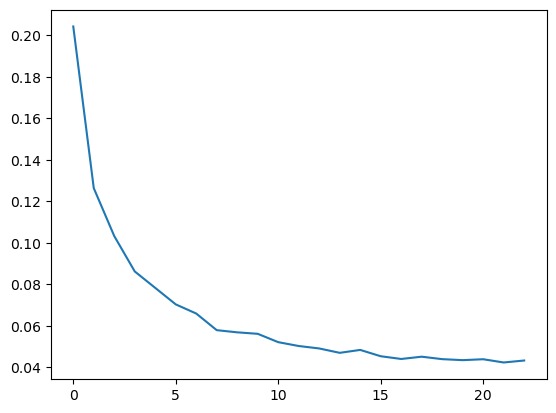

In [211]:
plt.plot(trainHist.history['loss'])


In [42]:
# model_name = 'gh_model_w512'
# model.save(save_path + model_name)

# encoder_name = 'gh_model_w512_encoder'
# encoded.save(save_path + encoder_name)

NameError: name 'encoded' is not defined

In [43]:
# model2 = tf.keras.models.load_model(save_path + 'gh_model_w512')
# model2.summary()

# encoded = tf.keras.models.load_model(save_path + 'gh_model_w512_encoder')

In [134]:
preds = np.squeeze(model.predict([sequences_test, temps_test]))
# preds = np.squeeze(model.predict(sequences_test))
preds_masked = np.squeeze(model.predict([sequences_masked, temps_test]))

64/64 [==============================] - 4s 55ms/step


### Temperature predictions

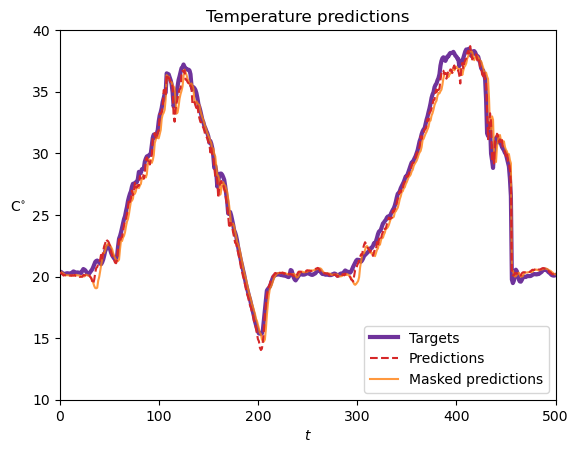

In [185]:
plt.plot(targets_test[:1000, 0] * col_params[('temperatures', 'TA01_GT10X_GM10X')]['std'] + col_params[('temperatures', 'TA01_GT10X_GM10X')]['mean'], 
         label='Targets',
         c='indigo',
         linewidth=3,
         alpha=0.8,
         zorder=1
)

plt.plot(preds[:1000, 0] * col_params[('temperatures', 'TA01_GT10X_GM10X')]['std'] + col_params[('temperatures', 'TA01_GT10X_GM10X')]['mean'], 
         label='Predictions',
         c='tab:red',
         ls='--',
         linewidth=1.5,
         alpha=1.0,
         zorder=3
)
plt.plot(preds_masked[:1000, 0] * col_params[('temperatures', 'TA01_GT10X_GM10X')]['std'] + col_params[('temperatures', 'TA01_GT10X_GM10X')]['mean'], 
         label='Masked predictions',
         c='tab:orange',
         linewidth=1.5,
         alpha=0.8,
         zorder=2
)

plt.ylim(10, 40)
plt.xlim(0, 500)
plt.xlabel('$t$')
plt.ylabel('C$^{\circ}$', rotation=0, labelpad=10)
plt.legend(loc='lower right')
plt.title('Temperature predictions')
plt.savefig(plot_path + 'lstm_512_temps.png', dpi=200)
plt.show()

### Humidity predictions

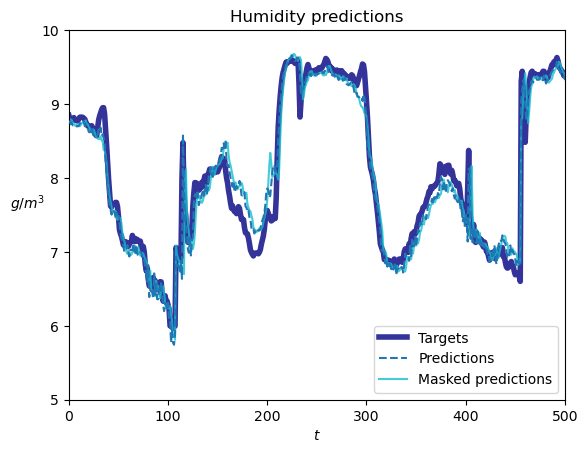

In [188]:
plt.plot(targets_test[:1000, 1] * col_params[('humidity', 'TA01_GT10X_GM10X_abs')]['std'] + col_params[('humidity', 'TA01_GT10X_GM10X_abs')]['mean'], 
         label='Targets',
         c='navy',
         linewidth=4,
         alpha=0.8,
         zorder=1
)

plt.plot(preds[:1000, 1] * col_params[('humidity', 'TA01_GT10X_GM10X_abs')]['std'] + col_params[('humidity', 'TA01_GT10X_GM10X_abs')]['mean'], 
         label='Predictions',
         c='tab:blue',
         ls='--',
         linewidth=1.5,
         alpha=1.0,
         zorder=3
)
plt.plot(preds_masked[:1000, 1] * col_params[('humidity', 'TA01_GT10X_GM10X_abs')]['std'] + col_params[('humidity', 'TA01_GT10X_GM10X_abs')]['mean'], 
         label='Masked predictions',
         c='tab:cyan',
         linewidth=1.5,
         alpha=0.8,
         zorder=2
)

plt.ylim(5, 10)
plt.xlim(0, 500)
plt.xlabel('$t$')
plt.ylabel('$g/m^3$', rotation=0, labelpad=10)
plt.legend(loc='lower right')
plt.title('Humidity predictions')
plt.savefig(plot_path + 'lstm_512_humid.png', dpi=200)
plt.show()

## PCA on ecoded stataes

In [44]:
from sklearn.decomposition import PCA

decomposer = PCA(n_components=3)

In [45]:
encodings = encoded.predict(sequences_masked)
decomposed = decomposer.fit_transform(X=encodings)

64/64 [==============================] - 5s 57ms/step


In [46]:
plt_data = pd.DataFrame(
    data=np.hstack((decomposed, targets_test)),
    columns=['pca_1', 'pca_2', 'pca_3', 'temps', 'humid']
)

plt_data.temps = plt_data.temps * col_params[('temperatures', 'TA01_GT10X_GM10X')]['std'] + col_params[('temperatures', 'TA01_GT10X_GM10X')]['mean']
plt_data.humid = plt_data.humid * col_params[('humidity', 'TA01_GT10X_GM10X_abs')]['std'] + col_params[('humidity', 'TA01_GT10X_GM10X_abs')]['mean']

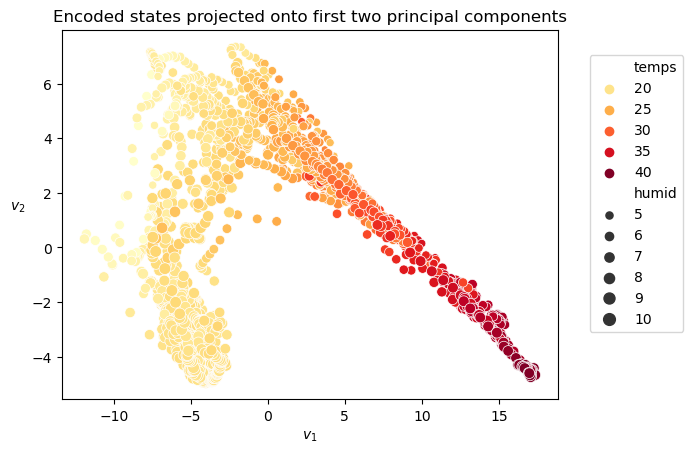

In [55]:
ax = sns.scatterplot(
    data=plt_data,
    x='pca_1',
    y='pca_2',
    hue='temps',
#     hue='humid',
    size='humid',
#     palette='Blues',
    palette='YlOrRd',
#     palette='YlOrBr'
)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1.05, 0.95))
ax.set_xlabel('$v_1$')
ax.set_ylabel('$v_2$', rotation=0, labelpad=10)
ax.set_title('Encoded states projected onto first two principal components')

# plt.savefig(plot_path + 'lstm_512_encoding.png', dpi=200, bbox_inches='tight')
plt.show()

## Heatmaps

In [102]:
#col_params

In [114]:
k = 100
n = 0

In [122]:
seq = sequences_masked[n, :, :].copy()
temp = temps_test[n-t_steps][0] * col_params[('temperatures', 'TA01_GT10X_GM10X')]['std'] + col_params[('temperatures', 'TA01_GT10X_GM10X')]['mean']
humid = temps_test[n-t_steps][1] * col_params[('humidity', 'TA01_GT10X_GM10X_abs')]['std'] + col_params[('humidity', 'TA01_GT10X_GM10X_abs')]['mean']

ta01_vals = np.arange(ta01_min, ta01_max, (ta01_max - ta01_min) / k)
ta02_vals = np.arange(ta02_min, ta02_max, (ta02_max - ta02_min) / k)

# ta01_vals = np.arange(0, 100, 100 / k)
# ta02_vals = np.arange(0, 100, 100 / k)

# ta01_minmax = (ta01_vals - ta01_min) / (ta01_max - ta01_min)
# ta02_minmax = (ta02_vals - ta02_min) / (ta02_max - ta02_min)

ta01_minmax = ta01_vals / ta01_min
ta02_minmax = ta02_vals / ta01_min

temp_dc = -temp + seq[:, 0].copy() * col_params[('temperatures', 'TA01_GT401_GM401')]['std'] +  col_params[('temperatures', 'TA01_GT401_GM401')]['mean']
# temp_out = -temp + seq[:, 1].copy() * col_params[('temperatures', 'DC_GT301_outdoor')]['std'] + col_params[('temperatures', 'DC_GT301_outdoor')]['mean']
temp_out = -temp + seq[:, 1].copy() * col_params[('temperatures', 'TA02_GT401_GM401')]['std'] + col_params[('temperatures', 'TA02_GT401_GM401')]['mean']

humid_dc = -humid + seq[:, 5].copy() * col_params[('humidity', 'TA01_GT401_GM401_abs')]['std'] +  col_params[('humidity', 'TA01_GT401_GM401_abs')]['mean']
# humid_out = -humid + seq[:, 6].copy() * col_params[('humidity', 'outdoor_abs')]['std'] +  col_params[('humidity', 'outdoor_abs')]['mean']
humid_out = -humid + seq[:, 6].copy() * col_params[('humidity', 'TA02_GT401_GM401_abs')]['std'] +  col_params[('humidity', 'TA02_GT401_GM401_abs')]['mean']

seqs = []

for i in range(100):
    for j in range(100):
        
        seq = sequences_masked[n, :, :].copy()
        
        ta01_temp = temp_dc * ta01_minmax[i]
        ta02_temp = temp_out * ta02_minmax[j]
        
        ta01_humid = humid_dc * ta01_minmax[i]
        ta02_humid = humid_out * ta02_minmax[j]
        
#         temp_inflow = ta01_temp + ta02_temp
#         humid_inflow = ta01_humid + ta02_humid
        
#         temp_inflow = (temp_inflow - col_params[('temperatures', 'TA_inflow')]['mean']) / col_params[('temperatures', 'TA_inflow')]['std']
#         humid_inflow = (humid_inflow - col_params[('humidity', 'TA_inflow')]['mean']) / col_params[('humidity', 'TA_inflow')]['std']

#         ta01_val = (ta01_vals[i] - col_params[('state', 'TA01_output')]['mean']) / col_params[('state', 'TA01_output')]['std']
#         ta02_val = (ta02_vals[j] - col_params[('state', 'TA02_output')]['mean']) / col_params[('state', 'TA02_output')]['std']
        ta01_temp = (ta01_temp - col_params[('temperatures', 'TA01_GT401_GM401_scaled')]['mean']) / col_params[('temperatures', 'TA01_GT401_GM401_scaled')]['std']
        ta02_temp = (ta02_temp - col_params[('temperatures', 'TA02_GT401_GM401_scaled')]['mean']) / col_params[('temperatures', 'TA02_GT401_GM401_scaled')]['std']
#         ta02_temp = (ta02_temp - col_params[('temperatures', 'DC_GT301_outdoor_scaled')]['mean']) / col_params[('temperatures', 'DC_GT301_outdoor_scaled')]['std']
        ta01_humid = (ta01_humid - col_params[('humidity', 'TA01_GT401_GM401_scaled')]['mean']) / col_params[('humidity', 'TA01_GT401_GM401_scaled')]['std']
        ta02_humid = (ta02_humid - col_params[('humidity', 'TA02_GT401_GM401_scaled')]['mean']) / col_params[('humidity', 'TA02_GT401_GM401_scaled')]['std']
#         ta02_humid = (ta02_humid - col_params[('humidity', 'outdoor_scaled')]['mean']) / col_params[('humidity', 'outdoor_scaled')]['std']

        
#         seq[-t_steps:, 0] = temp_inflow[-t_steps:]
#         seq[-t_steps:, 1] = humid_inflow[-t_steps:]

        seq[-t_steps:, 2] = ta01_temp[-t_steps:]
        seq[-t_steps:, 3] = ta02_temp[-t_steps:]
        seq[-t_steps:, 8] = ta01_humid[-t_steps:]
        seq[-t_steps:, 9] = ta02_humid[-t_steps:]
        
        seqs.append(seq)

In [123]:
seqs = np.stack(seqs)

In [124]:
# temps = model.predict(seqs)

# plt.plot(
#     ta01_vals,
#     temps * col_params[('temperatures', 'TA01_GT10X_GM10X')]['std'] + col_params[('temperatures', 'TA01_GT10X_GM10X')]['mean'],
#     c='r',
#     linewidth=2.0
# )

In [125]:
preds = model.predict([seqs, np.ones((10000, 1)) * temps_test[n]])
temps = np.reshape(preds[:, 0], (k, k)) * col_params[('temperatures', 'TA01_GT10X_GM10X')]['std'] + col_params[('temperatures', 'TA01_GT10X_GM10X')]['mean']
humids = rel_humid(temps, np.reshape(preds[:, 1], (k, k)) * col_params[('humidity', 'TA01_GT10X_GM10X_abs')]['std'] + col_params[('humidity', 'TA01_GT10X_GM10X_abs')]['mean'])

313/313 [==============================] - 18s 59ms/step


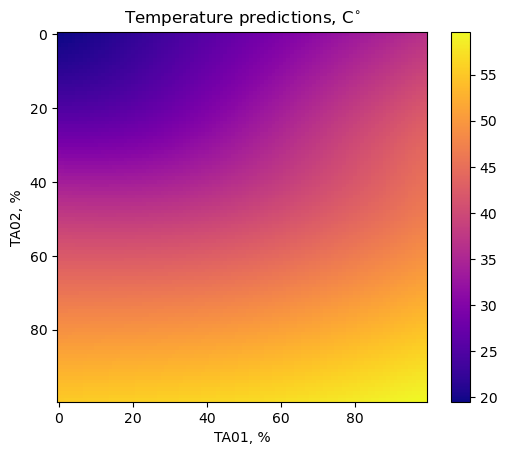

In [130]:
plt.imshow(temps.T, cmap='plasma')#, vmin=20, vmax=35)
plt.colorbar()

#plt.set_xticks(ta02_vals[::10])
#plt.xticks(ta02_vals[::10])

plt.xlabel('TA01, %')
plt.ylabel('TA02, %')

plt.title('Temperature predictions, C$^{\circ}$')
plt.savefig(plot_path + 'heatmap_temp.png', dpi=200)
plt.show()

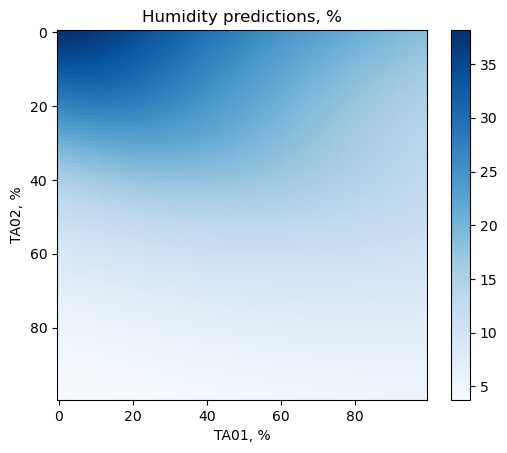

In [131]:
plt.imshow(humids.T, cmap='Blues')#, vmin=20, vmax=35)
plt.colorbar()

#plt.set_xticks(ta02_vals[::10])
#plt.xticks(ta02_vals[::10])

plt.xlabel('TA01, %')
plt.ylabel('TA02, %')

# plt.title('Humidity predictions, $g/m^3$')
plt.title('Humidity predictions, %')
plt.savefig(plot_path + 'heatmap_humid.png', dpi=200)
plt.show()

In [111]:
temp_dc

array([16.23475487, 16.15261315, 16.13207772, 16.13207772, 16.10469715,
       16.06362629, 16.08416172, 16.07731657, 15.96779428, 16.08416172,
       16.08416172, 16.08416172])

In [112]:
temp_out

array([21.74762992, 21.74762992, 21.74762992, 21.74762992, 21.74762992,
       21.74762992, 21.74762992, 21.74762992, 21.74762992, 21.74762992,
       21.74762992, 21.74762992])

In [121]:
temp #* col_params[('temperatures', 'TA01_GT10X_GM10X')]['std'] + col_params[('temperatures', 'TA01_GT10X_GM10X')]['mean']

18.553333333333335

In [62]:
humid

8.535317996076678